# California Water Usage Analysis: A Predictive Model

### Data Sources:
#### State of California Department of Finance Population Estimates dataset: https://dof.ca.gov/forecasting/demographics/estimates/e-4-population-estimates-for-cities-counties-and-the-state-2021-2025-with-2020-census-benchmark/

#### California Open Data Portal Urban Retail Water Supplier - Water Conservation, Supply, and Demand dataset: https://data.ca.gov/dataset/urws-conservation-supply-demand

## ==========================================================
### 1. IMPORT LIBRARIES & SETUP
## ==========================================================

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score

## ==========================================================
### 2. LOAD & CLEAN DATA
## ==========================================================

In [22]:
#California Open Data Portal Urban Retail Water Supplier Dataset
df = pd.read_csv("/Users/kdorion/Documents/MSAE/2025/Summer 2025/ECON698/FINAL PROJECT/suppliers.csv") 
df.dropna(axis=1, how='all', inplace=True)

## ==========================================================
### 3. IMPUTE MISSING VALUES
## ==========================================================

In [33]:
# Fill flag columns with mode
flag_cols = [
    'POTABLE_SUPPLY_MINUS_SOLD_FLAG', 
    'POTABLE_SUPPLY_MINUS_SOLD_MINUS_AG_GAL_FLAG', 
    'DWR_STANDARD_LEVEL_FLAG', 
    'RES_FLAG'
]
for col in flag_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill volume columns with median
volume_cols = [
    'POTABLE_SUPPLY_GAL', 'POTABLE_VOL_SOLD_GAL', 'POTABLE_DEMAND_AG_GAL',
    'POTABLE_DEMAND_CII_IRR_GAL', 'POTABLE_DEMAND_CII_GAL',
    'POTABLE_DEMAND_IRR_GAL', 'POTABLE_DEMAND_O_GAL', 'RECYCLED_DEMAND_GAL'
]

df[volume_cols] = SimpleImputer(strategy='median').fit_transform(df[volume_cols])
# Drop null R-GPCD values
df = df[df['R-GPCD'].notna()]

## ==========================================================
### 4. FEATURE ENGINEERING
## ==========================================================

In [36]:
# Create NET_USAGE_GAL and filter out invalid rows
df['NET_USAGE_GAL'] = df['POTABLE_SUPPLY_GAL'] - df['POTABLE_VOL_SOLD_GAL']
df = df[~((df['REPORT_PERIOD_START_DATE'].astype(str).str.contains("2023")) & (df['NET_USAGE_GAL'] < 0))]

# Create month feature for seasonality
df['MONTH'] = pd.to_datetime(df['REPORT_PERIOD_START_DATE']).dt.month

## ==========================================================
### 5. DEFINE FEATURES & TARGET
## ==========================================================

In [38]:
# Define features and target
features = volume_cols + ['NET_USAGE_GAL', 'CLIMATE_ZONE', 'HYDRO_REGION', 'MONTH']
X = df[features]
y = df['R-GPCD']

## ==========================================================
### 6. PREPROCESSING PIPELINE
## ==========================================================

In [42]:
# Pipeline for preprocessing
numeric_features = volume_cols + ['NET_USAGE_GAL', 'MONTH']
categorical_features = ['CLIMATE_ZONE', 'HYDRO_REGION']

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

## ==========================================================
### 7. MODEL TRAINING (Random Forest)
## ==========================================================

In [45]:
# Full pipeline with Random Forest
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit model and predict
model.fit(X, y)
y_pred = model.predict(X)

## ==========================================================
### 8. MODEL EVALUATION
## ==========================================================

In [48]:
# Evaluating Variance and Error
r2 = r2_score(y, y_pred)
rmse = root_mean_squared_error(y, y_pred)
print(f"R²: {r2:.4f}, RMSE: {rmse:.2f}")

R²: 0.9338, RMSE: 200883.20


## ==========================================================
### 9. FEATURE IMPORTANCE ANALYSIS
## ==========================================================

In [50]:
# Extract feature importances
rf = model.named_steps['regressor']
encoded_cat_cols = model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_cols)
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Custom label mapping for improved readability
label_map = {
    'POTABLE_DEMAND_CII_GAL': 'CII Water Demand (Commercial/Industrial/Institutional)',
    'POTABLE_DEMAND_CII_IRR_GAL': 'CII Irrigation Demand (Landscaping)',
    'POTABLE_DEMAND_AG_GAL': 'Agricultural Water Demand',
    'POTABLE_DEMAND_IRR_GAL': 'Landscape Irrigation Demand',
    'POTABLE_DEMAND_O_GAL': 'Other Potable Water Demand',
    'POTABLE_SUPPLY_GAL': 'Total Potable Supply',
    'POTABLE_VOL_SOLD_GAL': 'Total Potable Water Sold',
    'RECYCLED_DEMAND_GAL': 'Recycled Water Demand',
    'NET_USAGE_GAL': 'Unaccounted Water Use',
    'MONTH': 'Month (Seasonality)',
    'CLIMATE_ZONE_9': 'Climate Zone 9',
    'CLIMATE_ZONE_12': 'Climate Zone 12',
    'HYDRO_REGION_South Coast': 'South Coast Region',
    'HYDRO_REGION_Tulare Lake': 'Tulare Lake Region'
}

# Replace feature names with readable labels
feature_importance_df['Feature'] = feature_importance_df['Feature'].replace(label_map)

# Add predictions and residuals
df['PREDICTED_R_GPCD'] = y_pred
df['RESIDUAL'] = df['R-GPCD'] - df['PREDICTED_R_GPCD']

## ==========================================================
### 10. EXPORT MODEL OUTPUT
## ==========================================================

In [53]:
# Export final DataFrame
export_cols = [
    'ORG_ID', 'SUPPLIER_NAME', 'WATER_SYSTEM_ID', 'COUNTY',
    'HYDRO_REGION', 'CLIMATE_ZONE', 'REPORT_PERIOD_START_DATE',
    'R-GPCD', 'PREDICTED_R_GPCD', 'RESIDUAL'
] + features
df[export_cols].to_csv("final_randomforest_model_output.csv", index=False)

## ==========================================================
### 11. VISUALIZATIONS
## ==========================================================

/var/folders/6j/pmgy91ns295gxlfrv0dz53bmt6tjzs/T/ipykernel_71393/1350054918.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette="Blues")


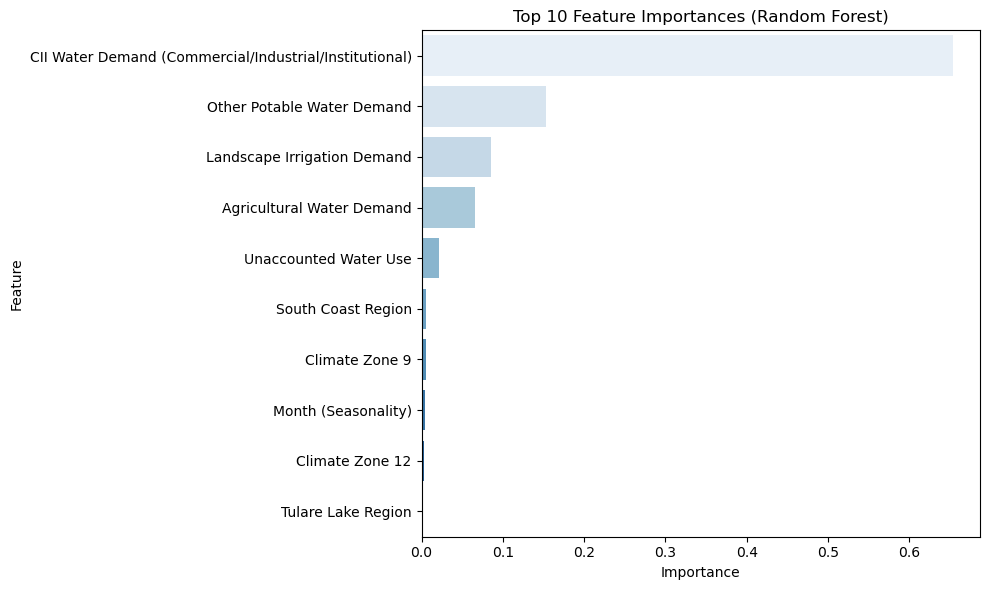

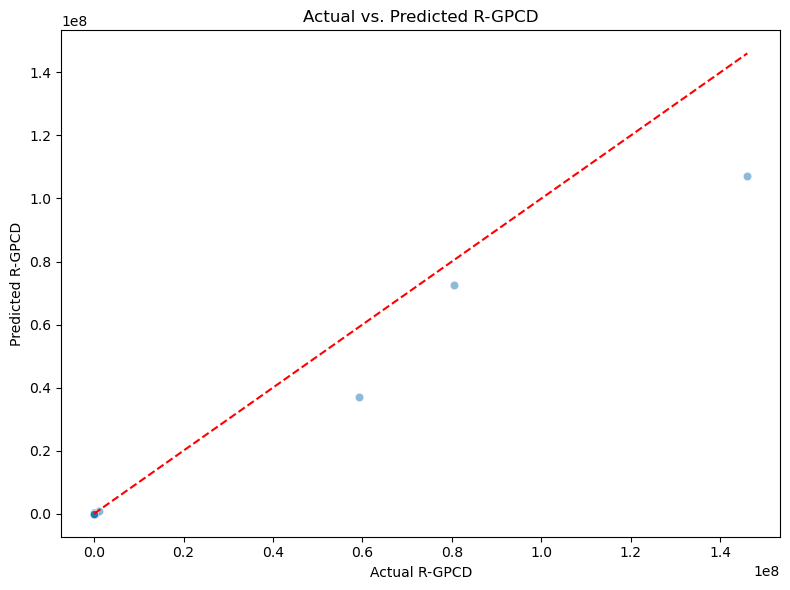

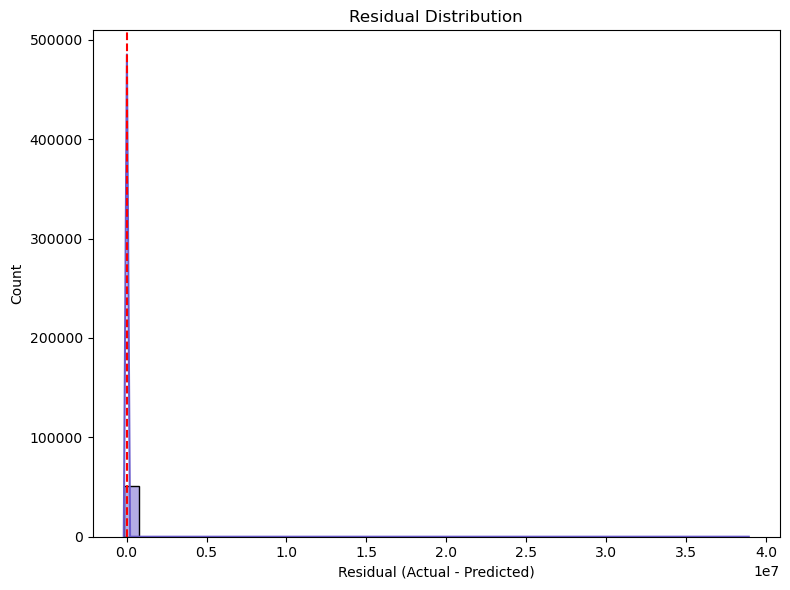

In [56]:
# Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette="Blues")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# Actual vs. Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['R-GPCD'], y=df['PREDICTED_R_GPCD'], alpha=0.5)
plt.plot([df['R-GPCD'].min(), df['R-GPCD'].max()],
         [df['R-GPCD'].min(), df['R-GPCD'].max()], 'r--')
plt.xlabel("Actual R-GPCD")
plt.ylabel("Predicted R-GPCD")
plt.title("Actual vs. Predicted R-GPCD")
plt.tight_layout()
plt.show()

# Residuals
plt.figure(figsize=(8, 6))
sns.histplot(df['RESIDUAL'], bins=40, kde=True, color='slateblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()